In [1]:
### Create pickled data file.

import numpy as np
import pickle
import cv2
import csv
import os


# Constants
path_img = './Recording_Udacity/IMG/'
path_csv = './Recording_Udacity/driving_log.csv'
img_height = 64
img_width = 64


def load_all(directory, csv_file):

    # Initialize 2 numpy arrays for X_train and y_train
    l = len(os.listdir(directory))
    x = np.zeros((l, img_height, img_width, 3), dtype='uint8')
    y = np.zeros(l, dtype='float32')

    # Initialize counter for adding data to X_train and y_train
    counter = 0

    # Loop through training images
    for f in os.listdir(directory):

        # Open csv file
        with open(csv_file, 'r') as file:
            reader = csv.reader(file)

            # Find corresponding label to image f
            # Assign correct steering angle to y_train
            for line in reader:
                # Center
                if (line[0] == ('IMG/'+f)):
                    y[counter] = line[3]
                    break
                
                # Left - Add space ' IMG/...' in csv file
                elif (line[1] == (' IMG/'+f)):
                    y[counter] = float(line[3]) + 0.25
                    break
                
                # Right - Add space ' IMG/...' in csv file
                elif (line[2] == (' IMG/'+f)):
                    y[counter] = float(line[3]) - 0.25
                    break

        # Read in image f
        img = cv2.imread(directory + f, 1)

        # Crop sky and car bonnet out
        img = img[55:135, :, :]
        
        # Resize image
        img = cv2.resize(img, (img_width, img_height))

        # OpenCV imports as BGR and we want RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Add image f to X_train. Left, Right or Center does not matter
        # as the correct turning angle has been assigned above
        x[counter] = img

        # Increment counter
        counter += 1

    return x, y

# Load data
X_train, y_train = load_all(path_img, path_csv)

# Print data info
print('X_train length', len(X_train), 'shape', X_train.shape, 'type', X_train.dtype)
print('y_train length', len(y_train), 'shape', y_train.shape, 'type', y_train.dtype)

# Create dictionary
dict = {'features': X_train, 'labels': y_train}

# Write to pickle file
pickle.dump(dict, open("data.p", "wb"))

X_train length 24108 shape (24108, 64, 64, 3) type uint8
y_train length 24108 shape (24108,) type float32


X_train length 24108 shape (24108, 64, 64, 3) type uint8
y_train length 24108 shape (24108,) type float32
Data loaded successfully


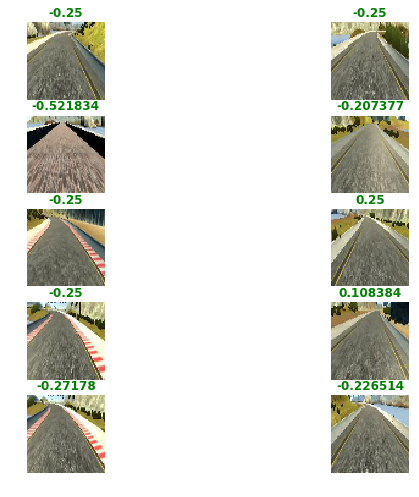

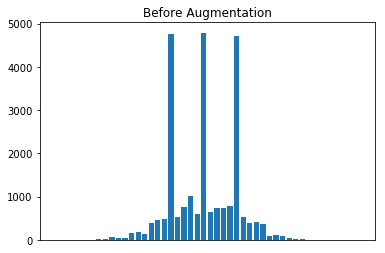

In [ ]:
### Load pickled data file.

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

with open('./data.p', mode='rb') as f:
    train = pickle.load(f)

X_train, y_train = train['features'], train['labels']

# Print data info
print('X_train length', len(X_train), 'shape', X_train.shape, 'type', X_train.dtype)
print('y_train length', len(y_train), 'shape', y_train.shape, 'type', y_train.dtype)
print('Data loaded successfully')

# Display n random images
def display_images(X_train, y_train, n):
    index = np.random.randint(0, len(y_train), size=(1, n, 1))
    index = index[0]
    fig = plt.figure(figsize=(10, 10))

    for i in range(n):
        img = X_train[int(index[i][0])]
        ax = fig.add_subplot((n/2)+1, 2, i+1)
        ax.set_title(y_train[index[i][0]], fontsize=12, fontweight='bold', color='green')
        plt.axis('off')
        plt.imshow(img)

# Display number of images per turning angle
def display_histogram(data, title):
    n_col = 50
    hist, bin_edges = np.histogram(data, bins=n_col)
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1, 1, 1)

    plt.bar(np.arange(n_col), hist)
    plt.xlim([-1, n_col])
    plt.xticks([])
    plt.title(title)
    plt.show()

# Display processed images
display_images(X_train, y_train, 10)

# Display dataset prior augmentation
display_histogram(y_train, 'Before Augmentation')

Using TensorFlow backend.


X_train length 36442 shape (36442, 64, 64, 3) type uint8
y_train length 36442 shape (36442,) type float32
X_val   length 6432  shape (6432, 64, 64, 3) type uint8
y_val   length 6432  shape (6432,) type float32


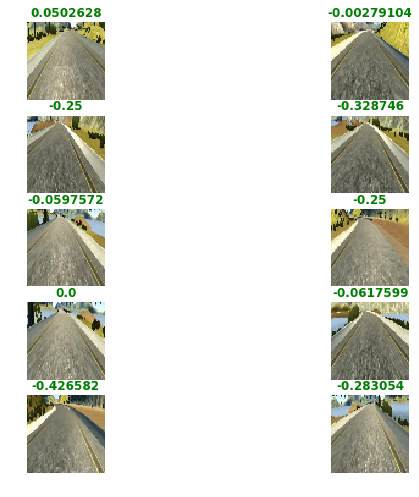

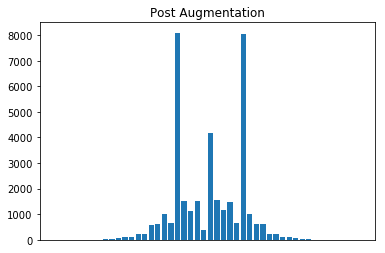

Epoch 1/10
18176/18221 [============================>.] - ETA: 0s - loss: 0.6330  

/home/david/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


18304/18221 [==============================] - 30s - loss: 0.6323 - val_loss: 0.7867
Epoch 2/10
18266/18221 [==============================] - 29s - loss: 0.4158 - val_loss: 0.4947

In [ ]:
### model.py

import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from keras import backend as K

# Fix error with Keras and TensorFlow
import tensorflow as tf
tf.python.control_flow_ops = tf


# Constants from creating pickled data file
img_height = 64
img_width = 64


# Flip images around the vertical and add them to the input features and labels
def flipLR(X_train, y_train):

    # Set all values outside the condition limits to 0
    condlist = [y_train<-0.05, y_train>0.05]
    choicelist = [y_train, y_train]
    y_train_new = np.select(condlist, choicelist)
    
    # Number of inputs != 0
    total_turning = np.count_nonzero(y_train_new)
    X = np.zeros((total_turning, img_height, img_width, 3), dtype=X_train.dtype)
    y = np.zeros(total_turning, dtype = y_train.dtype)
    counter = 0

    for i in range(len(y_train_new)):
        if y_train_new[i] != 0:
            # Flip image
            X[counter] = np.fliplr(X_train[i])
            # Swap angle sign
            y[counter] = -(y_train[i])
            counter += 1

    X_ = np.concatenate((X_train, X), axis = 0)
    y_ = np.concatenate((y_train, y), axis = 0)

    return X_, y_


# Use BatchNormalization between the linear and non-linear layers.
# It normalizes the input to the activation function so that
# the linear section of the activation function is centered.
def sequential_model(X_train, y_train, X_val, y_val, batch_size,
                     nb_train_samples, nb_val_samples, nb_epoch):

    model = Sequential()
    model.add(BatchNormalization(input_shape=(img_height, img_width, 3)))

    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(56, 3, 3, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.5))

    model.add(Dense(50))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(BatchNormalization())
    model.add(Activation('linear'))

    # Compile model
    model.compile(optimizer='adam', loss='mse')

    # Define data processing
    datagen = ImageDataGenerator()
    
    # Training generator
    train_generator = datagen.flow(X_train, y_train, batch_size, shuffle=True)

    # Validation generator
    val_generator = datagen.flow(X_val, y_val, batch_size, shuffle=True)

    # Initialize values for BatchNormalization layer
    K.get_session().run(tf.global_variables_initializer())

    # Train model
    model.fit_generator(train_generator, nb_train_samples, nb_epoch,
                        validation_data=val_generator, nb_val_samples=nb_val_samples)

    # Save the model architecture as a JSON string
    json_string = model.to_json()
    open('model.json', 'w').write(json_string)

    # Saves the weights of the model as a HDF5 file
    model.save_weights('model.h5')

    # Display model summary
    model.summary()


def main(X_train, y_train):

    # Image augmentation
    X_train, y_train = flipLR(X_train, y_train)

    # Split input data into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

    print('X_train length', len(X_train), 'shape', X_train.shape, 'type', X_train.dtype)
    print('y_train length', len(y_train), 'shape', y_train.shape, 'type', y_train.dtype)
    print('X_val   length', len(X_val), ' shape', X_val.shape, 'type', X_val.dtype)
    print('y_val   length', len(y_val), ' shape', y_val.shape, 'type', y_val.dtype)

    # Display augmented images
    display_images(X_train, y_train, 10)

    # Display dataset post augmentation
    display_histogram(y_train, 'Post Augmentation')

    # Hyperparamters
    batch_size = 128
    nb_train_samples = int(len(y_train) / 2)
    nb_val_samples = int(len(y_val) / 2)
    nb_epoch = 10

    # Run model
    sequential_model(X_train, y_train, X_val, y_val, batch_size,
                     nb_train_samples, nb_val_samples, nb_epoch)


# Calls the `main` function above
main(X_train, y_train)

In [ ]:
### Load saved model and weights

from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG


# Load model
with open(args.model, 'r') as jfile:
    model = model_from_json(jfile.read())

# Load weights
model.compile("adam", "mse")
weights_file = args.model.replace('json', 'h5')
model.load_weights(weights_file)